# Neural Style Transfer with Keras
This notebook is based on Chapter 8.3 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python) by F. Chollet. Original article "A Neural Algorithm of Artistic Style" by Leon Gatys et al. can be found in [arXiv](https://arxiv.org/abs/1508.06576).

Neural style transfer means applying the style of a reference image to a target image while preserving the content of the target image. Here "style" means textures, colors, and visual patterns in the image. The content is the higher-level structure of the image. The loss function is heuristically defined as
```python
loss = dist(style(reference) - style(generated)) + dist(content(original) - content(generated)),
```
where `reference` is the reference image (from which style is copied), `original` is the image where style is being applied, and `generated` is the generated image. Minimizing this loss means that
```
style(generated) $\approx$ style(reference)
```
and 
```
content(generated) $\approx$ content(original)
```
as we want.

The key observation made in the paper by L. Gatys et al. was that convolutional networks (convnets) present a way to mathematically define `style` and `content` functions. The activations of the different layers of a convnet provide a decomposition of the contents of an image over different scales. The content of the image, which is a global and abstract property, is captured by the representations in the higher (later) layers of the convnet. 

The style loss as defined by Gatys et al. uses multiple layers of a convnet, as we want to capture the appearance of the reference image at all spatial scales extracted by the convnet. Gatys et al. use the _Gram matrix_ of a layer's activations as style loss, i.e., the inner product of the feature maps of a given layer. 

We now move on to the implementation following the general process:
1. Set up a network that computes the layer activations for the style-reference image, target image, and the generated image.
2. Use the computed layer activations to compute the loss function.
3. Set up gradient descent to minimize the loss.

We'll use the VGG19 as the pretrained convnet. Images are resized to a shared height of 400px.

In [3]:
from keras.preprocessing.image import load_img, img_to_array
style_reference_image_path = 'reference-images/starry-night.jpg'
target_image_path = 'input/bear.jpg'

width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

### Show the target image

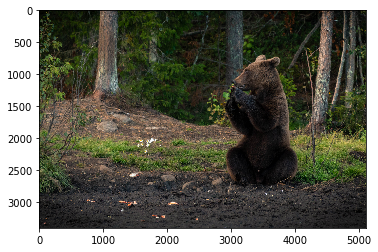

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
def show_img(image_path):
    img = mpimg.imread(image_path) # Numpy array
    plt.imshow(img)
    
show_img(target_image_path)

### Show the reference image

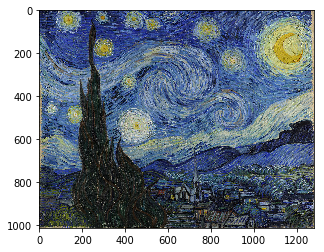

In [14]:
show_img(style_reference_image_path)

### Define preprocessing for VGG19

In [17]:
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

print("Shape of preprocessed target image:", preprocess_image(target_image_path).shape)
print("Shape of preprocessed reference image:", preprocess_image(style_reference_image_path).shape)

Shape of preprocessed target image: (1, 400, 600, 3)
Shape of preprocessed reference image: (1, 400, 600, 3)


In [22]:
def deprocess_image(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


### Define input tensors and pretrained model

In [23]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_height, img_width, 3))

input_tensor = K.concatenate([target_image, style_reference_image, combination_image], axis=0)

model = vgg19.VGG19(input_tensor=input_tensor,
                   weights='imagenet',
                   include_top=False)


80142336/80134624 [==============================] - 276s 3us/step


### Define content loss

In [24]:
def content_loss(base, combination):
    return K.sum(K.square(combination-base))

### Define style loss in terms of the Gram matrix

In [25]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

### Add regularization loss to encourage continuity

In [31]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - 
        x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - 
        x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

### Save layers in a dictionary

In [28]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
outputs_dict

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 400, 600, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 400, 600, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 200, 300, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 200, 300, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 200, 300, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 100, 150, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 100, 150, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 100, 150, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 100, 150, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(3, 100, 150, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 50, 75, 256) dtype=float32>,
 

### Define the layers used for computing style and content losses as well as loss itself

In [32]:
content_layer = 'block5_conv2'
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features, combination_features)

for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
    
loss += total_variation_weight * total_variation_loss(combination_image)

### Define Keras functions that compute gradients and losses for given input placeholder tensors

In [ ]:
grads = K.gradients(loss, combination_image)[0]
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

### Define a helper class that computes both the loss and gradient in one go

In [33]:
class Evaluator:
    def __init__(self):
        self.loss_value = None
        self.grad_values = None
    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
    
evaluator = Evaluator()

### Perform loss minimization using Scipy's L-BFGS

In [ ]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time
result_folder = 'results'
iterations = 5

x = preprocess_image(target_image_path)
x = x.flatten()

for i in range(iterations):
    print('Start of iteration: {}'.format(i))
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss,
                                    x,
                                    fprime=evaluator.grads,
                                    maxfun=20)
    print('Current loss value:', min_val)
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = os.path.join(result_folder, 'generated_at_iteration_%d.png' % i)
    imsave(fname, img)
    print('Image saved as', fname)
    end_time = time.time()
    print('Iteration %d completes in %d s' % (i, end_time - start_time))

Start of iteration: 0
Current loss value: 1464968600.0
Image saved as my_result_at_iteration_0.png
Iteration 0 completes in 236 s
Start of iteration: 1


/Users/ksaaskil/.pyenv/versions/3.5.0/envs/python3.5.0/lib/python3.5/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value: 554389570.0
Image saved as my_result_at_iteration_1.png
Iteration 1 completes in 236 s
Start of iteration: 2
